This code uses the freud package, alongwith PyLammps, to calculate the averaged RDF over a user-defined range of snapshots in a lammps trajectory file. 

In [1]:
import numpy as np
import time
from cycler import cycler
import matplotlib
from matplotlib import pyplot
from matplotlib.colors import colorConverter
myHexColors = ["#30A2DA", "#FC4F30", "#E5AE38", "#6D904F", "#9757DB", "#188487", "#FF7F00", "#9A2C66", "#626DDA", "#8B8B8B"]
myColorCycle = [colorConverter.to_rgb(i) for i in myHexColors]
from freud import parallel
parallel.setNumThreads(4)

from ipywidgets import IntProgress
from IPython.display import display

# matplotlib.rcParams.update({'font.sans-serif': 'Helvetica'})
# matplotlib.rcParams.update({'font.family': 'sans-serif'})
matplotlib.rcParams.update({'font.size': 24})
matplotlib.rcParams.update({'axes.labelsize': 24})
matplotlib.rcParams.update({'xtick.labelsize': 18})
matplotlib.rcParams.update({'ytick.labelsize': 18})
matplotlib.rcParams.update({'savefig.pad_inches': 0.025})
matplotlib.rcParams.update({"axes.prop_cycle": cycler(color=myColorCycle)})
matplotlib.rcParams.update({"lines.linewidth": 2})

# lammps
from lammps import lammps, PyLammps
lmp = lammps()
L = PyLammps(ptr=lmp) # Get PyLammps


LAMMPS output is captured by PyLammps wrapper


All the user-defined stuff is in the next section :

In [2]:
# User-defined stuff
system = 'liq'
typeID = 1
frameNo = 500000 #500000
endFrame = 1000000 #1000000
dumpFreq = 5000 #1000 #5000
nFrames = int((endFrame - frameNo)/dumpFreq) + 1
# Dumpfile name to read from 
dumpfile = 'traj/dump-' + system + '.lammpstrj'

Average the RDF over the frames specified by frameNo and endFrame (inclusive of both). If you specify a frame that is not present in the lammps trajectory file, PyLammps will throw an error. 

If you run the cell below more than once, make sure to uncomment the PyLammps command for reading in the data file, or else you will get a Lammps error.

IntProgress(value=1, max=101, min=1)

Frame number  500000
Frame number  505000
Frame number  510000
Frame number  515000
Frame number  520000
Frame number  525000
Frame number  530000
Frame number  535000
Frame number  540000
Frame number  545000
Frame number  550000
Frame number  555000
Frame number  560000
Frame number  565000
Frame number  570000
Frame number  575000
Frame number  580000
Frame number  585000
Frame number  590000
Frame number  595000
Frame number  600000
Frame number  605000
Frame number  610000
Frame number  615000
Frame number  620000
Frame number  625000
Frame number  630000
Frame number  635000
Frame number  640000
Frame number  645000
Frame number  650000
Frame number  655000
Frame number  660000
Frame number  665000
Frame number  670000
Frame number  675000
Frame number  680000
Frame number  685000
Frame number  690000
Frame number  695000
Frame number  700000
Frame number  705000
Frame number  710000
Frame number  715000
Frame number  720000
Frame number  725000
Frame number  730000
Frame number 

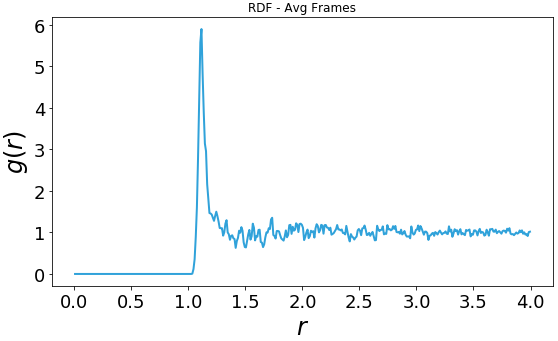

<Figure size 432x288 with 0 Axes>

In [3]:
# import the freud object
# the rdf module is contained in the density module
from freud import box, density

# create the rdf object
# make rmax less than half the box?
rdf = density.RDF(rmax=4.0, dr=0.01) # 0.01

# compute the rdf for for all frames except the first 

# Current frame
frame = frameNo

# compute the rdf for for all frames except the first (your syntax will vary based on your reader)
myProgressBar = IntProgress(min=1,max=nFrames)
display(myProgressBar)

# Lammps init
# load the data
# Read in the lammps input file
lmp.file('lammpsFiles/inp.'+ system) # LAMMPS input file for the system
# Get the number of atoms of one typeID
natoms = 0
L.read_dump(dumpfile, frameNo, "x y z box yes replace yes")
for i in range(L.atoms.natoms):
    if L.atoms[i].type==typeID:
        natoms += 1
# Define numPy coordinate array; here natoms is the no. of atoms of type 1
x = np.zeros((natoms,3), dtype=float)

start_time = time.time()
for i in range(nFrames):
    # Progress bar
    myProgressBar.value = int(frame/dumpFreq)
    # --------------------------
    # Lammps stuff
    # read box, position data from the lammps dumpfile
    L.read_dump(dumpfile, frame, "x y z box yes replace yes")
    # Get coord
    # Assigning values to numpy array x
    for i in range(L.atoms.natoms):
        if L.atoms[i].type==typeID:
            for k in range(3):
                x[i][k] = L.atoms[i].position[k]          
    box_limits = [L.system.xhi-L.system.xlo, L.system.yhi-L.system.ylo, L.system.zhi-L.system.zlo] # box from lammps
    # --------------------------
    # create the freud box object
    fbox = box.Box(Lx=box_limits[0], Ly=box_limits[1], Lz=box_limits[2])    

    # accumulate
    rdf.accumulate(fbox, x, x)

    # ----------------------------
    # Update frame number
    print("Frame number ", frame)
    frame = frame + dumpFreq
stop_time = time.time()
print("time to calc {} frames = {}".format(nFrames, stop_time-start_time))
print("speed of calc: {} (frames/sec)".format((nFrames)/(stop_time-start_time)))

# get the center of the histogram bins
r = rdf.getR()
# get the value of the histogram bins
y = rdf.getRDF()

pyplot.figure(figsize=(8, 5))
pyplot.title("RDF - Avg Frames")
pyplot.plot(r, y)
pyplot.xlabel(r"$r$")
pyplot.ylabel(r"$g\left(r\right)$")
pyplot.tight_layout()
pyplot.show()
pyplot.savefig('averaged_RDF.png')